# MySQL Database Administration

In [1]:
import sys
import pandas as pd
import geopandas as gpd
from pathlib import Path

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
proj_dir = Path("../../..")

In [3]:
utils = str(proj_dir / 'utils')
sys.path.insert(0, utils)
from sql import connect # utility functions for connecting to MySQL

In [9]:
# Create a connection object to the MySQL database
# conn = connect.Connect('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Methods/database_management/mysql_config.ini')
conn = connect.Connect(str(proj_dir / ".env/mysql_config.ini"))
cursor = conn.conn.cursor()

Connecting to MySQL database...
Connection established.


In [8]:
data_dir = proj_dir / "Data/InSituTemperature"
# insitu_reach_key = pd.read_csv(data_dir / "insitu_reach_key.csv")
insitu_reach_key = gpd.read_file("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/temp_timeseries/insitu_reach_key.shp")
# insitu_reach_key = gpd.read_file(data_dir / "insitu_reach_key.shp")
# insitu_reach_key.head()

In [10]:
for index, row in insitu_reach_key.iterrows():
    insitu_data = pd.read_csv(data_dir / "processed" / f"{row['source']}_{row['id']}.csv")
    insitu_data['date'] = pd.to_datetime(insitu_data['date']).dt.strftime('%Y-%m-%d')
    insitu_data.dropna(subset=['avg water temperature (C)'], inplace=True)

    # add values to the database
    for i, r in insitu_data.iterrows():
        query = f"""
        INSERT INTO ReachInsituWaterTemp (Date, ReachID, Value)
        SELECT "{r['date']}", (SELECT ReachID FROM Reaches WHERE Name = "{row['reach_id']}"), {r['avg water temperature (C)']}
        WHERE NOT EXISTS (SELECT * FROM ReachInsituWaterTemp WHERE Date = "{r['date']}" AND ReachID = (SELECT ReachID FROM Reaches WHERE Name = "{row['reach_id']}"));
        """
        cursor.execute(query)
        conn.conn.commit()

        # print(f"Inserted {r['date']} for {row['reach_id']}")

        # break

    # break


In [11]:
query = """
SELECT 
    *
FROM
    (SELECT 
        STR_TO_DATE(CONCAT(YEAR(ReachLandsatWaterTemp.date), '-', LPAD(MONTH(ReachLandsatWaterTemp.date), 2, '00'), '-', LPAD(IF(DAY(ReachLandsatWaterTemp.date) < 15, 1, 15), 2, '00')), '%Y-%m-%d') AS Date,
            AVG(ReachLandsatWaterTemp.Value) AS WaterTemp,
            ReachLandsatWaterTemp.ReachID AS ReachID
    FROM
        ReachLandsatWaterTemp
    INNER JOIN Reaches USING (ReachID)
    WHERE
        ReachLandsatWaterTemp.Value > 0
    GROUP BY Date , ReachID) AS L
        INNER JOIN
    (SELECT 
        STR_TO_DATE(CONCAT(YEAR(ReachInsituWaterTemp.date), '-', LPAD(MONTH(ReachInsituWaterTemp.date), 2, '00'), '-', LPAD(IF(DAY(ReachInsituWaterTemp.date) < 15, 1, 15), 2, '00')), '%Y-%m-%d') AS Date,
            AVG(ReachInsituWaterTemp.Value) AS InsituTemp,
            ReachInsituWaterTemp.ReachID AS ReachID
    FROM
        ReachInsituWaterTemp
    INNER JOIN Reaches USING (ReachID)
    WHERE
        ReachInsituWaterTemp.Value > 0
    GROUP BY Date , ReachID) AS I USING (Date , ReachID)
"""

df = conn.query_with_fetchmany(query, chunksize=100)

In [12]:
# df = pd.concat([chunk for chunk in data], ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.head(100)

,Date,ReachID,WaterTemp,InsituTemp
0,2013-03-15,1060,10.9863,8.6
1,2013-03-15,1060,10.9863,8.6
2,2013-03-15,1060,10.9863,8.4
3,2013-03-15,1060,10.9863,8.2
4,2013-03-15,1060,10.9863,8.3
...,...,...,...,...
95,2013-03-15,600,11.4453,8.1
96,2013-03-15,600,11.4453,8.7
97,2013-03-15,600,11.4453,9.0
98,2013-03-15,600,11.4453,10.0


In [14]:
# df.to_csv(data_dir / "insitu_landsat.csv", index=False)

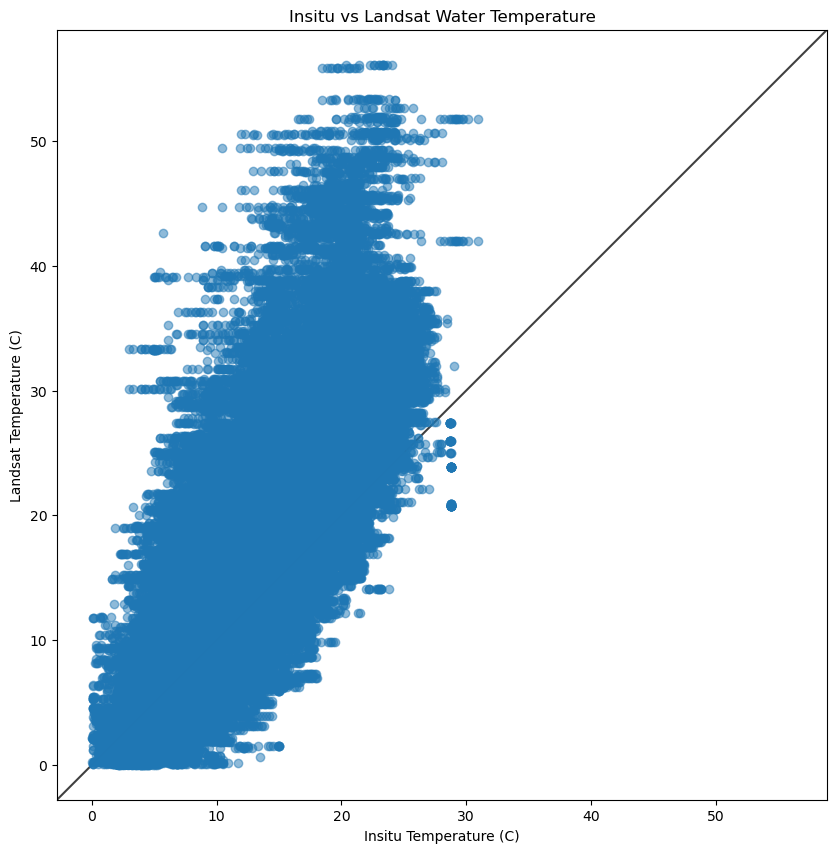

In [15]:
# scatter plot of the data
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df['InsituTemp'], df['WaterTemp'], alpha=0.5)
ax.set_xlabel("Insitu Temperature (C)") 
ax.set_ylabel("Landsat Temperature (C)")
ax.set_title("Insitu vs Landsat Water Temperature")

# add 1:1 line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()
